
<h1 style="color: #8B0000; font-size: 30pt; text-align: center; padding-bottom: 5px; ">
     NETTI_flix &nbsp; ELLA_lytics 
</h1>

<h2 style="color: #8B0000; font-size: 22pt; text-align: center;">
    LLM Project: &nbsp; "What Movie Can I Watch Next?"
</h2>


<p style="font-size: 12pt; line-height: 1.4;">
    This project started after watching our favourite movie Ratatouille, and wanting to watch something similar afterwards.
    It made us think, how do Streaming platforms recommend these "What to watch next"- movies? 
</p>
<p style="font-size: 12pt; line-height: 1.4;">
    We want to try rebuilding a <span style="color: #FF1493; font-size: 12pt; font-weight: bold;">MOVIE RECOMMENDER SYSTEM</span> that could intelligently suggest movies based on semantic similarities that matched the deep, subtle 'vibe' of our favorites.  
</p> 
<p style="font-size: 12pt; line-height: 1.4;">
    However, how do we know those movies are actually good? This is where we want to analyze reviews, and classify them. We conduct a <span style="color: #FF1493; font-size: 12pt; font-weight: bold;">MOVIE REVIEW SENTIMENT ANALYSIS AND CLASSIFICATION</span>.
</p>
<p style="font-size: 12pt; line-height: 1.4;">
    We essentially analyze a Dual-LLM System for Contextual Movie Discovery in a <span style="color: #FF1493; font-size: 12pt; font-weight: bold;">COMBINATION</span>. 
</p>
  

<h1 style="color: #8B0000;"> PROJECT OVERVIEW</h1>
<ol style="font-size: 12pt; padding-left: 12px; margin-top: 4px;">
    <li style="color: #FF1493; margin-bottom: 4px;">
        <span style="color: black;">Movie Recommender System (Netti)</span>
    </li>
    <li style="color: #FF1493; margin-bottom: 4px;">
        <span style="color: black;">Movie Review Sentiment Analysis and Classification (Ella)</span>
    </li>
    <li style="color: #FF1493; margin-bottom: 4px;">
        <span style="color: black;">Combination (Both)</span>
    </li>
</ol>

<h1 style="color: #8B0000;"> 1. MOVIE RECOMMENDER SYSTEM</h1>

This part explores the evolution of a Movie Recommendation System using Large Language Models (LLMs). We begin with a standard semantic search approach and iteratively improve it through Feature Engineering and advanced Multi-Task Fine-Tuning.

*It will cover the following topics:*

1. **Data Setup:** Feature Engineering the "Metadata Soup".
2. **Baseline Model:** Standard Semantic Search.
3. **Limitation Analysis:** The "Vibe" Problem.
4. **Contrastive Fine-Tuning** Narrative Focus.
5. **Analysis:** Visualizing the Specificity Trade-off.
6. **Multi-Task Learning** Narrative Focus & Genre.
7. **Evaluation:** Comparing all approaches.

**<span style="color: #FF1493;">Setup and library imports</span>**

In [109]:
# Importing all necessary libraries
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import os
import torch
import requests

from getpass import getpass
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, classification_report
from transformers import pipeline, DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation, util
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from collections import Counter

# Visualization Settings
%matplotlib inline
sns.set(style = "whitegrid")

<h2 style="color: #8B0000;">1.1 Data Setup and Feature Engineering</h2>

**<span style="color: #FF1493;">Dataset Description</span>**

We are using the **TMDB 5000 Movies Dataset**. It contains metadata including titles, plot overviews, genres, and keywords. 

To allow the LLM to understand the full context of a movie, we cannot simply rely on the plot. We perform **Feature Engineering** to create a "Metadata Soup" of all relevant input text. It is being turned into a single string combining all textual features into a dense context vector. This is because our model is only able to calculate semantic embeddings for one input sequence at a time, so we must concatenate discrete features (like genres, keywords, and plot) into a single continuous text string to ensure the resulting vector captures more than the plot context of a movie.

In [2]:

dataset = load_dataset("AiresPucrs/tmdb-5000-movies", split = "train")
df = pd.DataFrame(dataset)

# Defining Preprocessing Functions
def parse_structure(x):
    if isinstance(x, list):
        return x
    try:
        return [i['name'] for i in ast.literal_eval(x)]
    except:
        return []

def join_features(x):
    if isinstance(x, list):
        return ' '.join(x)
    return ''

# Cleaning
df = df[['title', 'overview', 'genres', 'keywords', 'tagline']].fillna('')
df['genres'] = df['genres'].apply(parse_structure)
df['keywords'] = df['keywords'].apply(parse_structure)

# Creating the "Soup"
# We tell the model to use "Title + Genres + Keywords + Tagline + Overview"
df['soup'] = (
    df['title'] + " " + 
    df['genres'].apply(join_features) + " " + 
    df['keywords'].apply(join_features) + " " + 
    df['tagline'] + " " + 
    df['overview']
)

print(f"Dataset Loaded: {len(df)} movies.")
df.head(1)

Dataset Loaded: 4803 movies.


,title,overview,genres,keywords,tagline,soup
0,Four Rooms,It's Ted the Bellhop's first night on the job....,"[Crime, Comedy]","[hotel, new year's eve, witch, bet, hotel room...",Twelve outrageous guests. Four scandalous requ...,Four Rooms Crime Comedy hotel new year's eve w...


<h2 style="color: #8B0000;">1.2 Baseline Model: Semantic Search</h2>

**<span style="color: #FF1493;">Model Architecture</span>**

We utilize `all-MiniLM-L6-v2`, a pre-trained Sentence Transformer designed to map sentences to a 384-dimensional dense vector space. 

* **Input:** Movie "Soup" (Text Vectors)
* **Output:** Vector Embeddings
* **Metric:** Cosine Similarity


In [3]:
# Loading the pre-trained model
baseline_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

print("Generating Baseline Embeddings...")
baseline_embeddings = baseline_model.encode(df['soup'].tolist(), show_progress_bar=True)

Generating Baseline Embeddings...


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

<h3 style="color: #8B0000;">Why Plot Only is Not Enough Context for the Model</h3>

**<span style="color: #FF1493;">Justification for Feature Engineering (The "Plot Only" Problem)</span>**

Before constructing our baseline model, we just used the **`overview`** (plot summary) column.
This proved a severe limitation that is **Keyword Dominance**. For example, entering the plot summary for *Ratatouille* (a family animation movie) would yield the following top recommendation:

**Actual Result of a previous function only including overview:**
* Perfume: The Story of a Murderer (Confidence: 0.44)
* Genres: ['Crime', 'Fantasy', 'Drama']
    
This classic error occurs because the generic pre-trained model latches onto shared keywords like **"Smell," "Paris,"** and **"protagonist with an obsession,"** completely ignoring the core **Family/Animation** genre.
To prevent this immediate failure and force the model to consider genre, keywords, and tagline from the start, we engineered the rich **Metadata Soup**. The demonstration in the next section shows the **improved Baseline** result that successfully leverages this richer context.

In [4]:
def recommend(movie_name, model_obj, embeddings_matrix, description = None):
   
    titles_lower = df['title'].str.lower().tolist()
    input_lower = movie_name.lower() 
    target_embedding = None 
 
    # If the movie is in dataset
    if input_lower in titles_lower:
        idx = titles_lower.index(input_lower)
        real_title = df.iloc[idx]['title'] 
        target_embedding = embeddings_matrix[idx]

    # If the movie is not in the dataset (Cold Start)
    else:
        real_title = movie_name.title()
        if description is None:
            print(f"I have not seen the movie '{real_title}'. Please provide a description.")
            return
        target_embedding = model_obj.encode([description])[0]
        
    # Calculating Similarity
    scores = cosine_similarity([target_embedding], embeddings_matrix).flatten()
    top_indices = scores.argsort()[::-1][0:5]
    
    print(f"\n Recommendations for \"{real_title}\":")
    print("-" * 40)
    
    count = 0
    for i in top_indices:
        title = df.iloc[i]['title']
        # Skip self
        if title.lower() == input_lower: continue
            
        score = scores[i]
        genres = df.iloc[i]['genres'] 
        
        print(f"• {title}")
        print(f"  Score: {score:.2f}") 
        print(f"  Genres: {genres}") 
        print("-" * 40)

        count += 1
        if count == 3: break
    print("\n")

# Testing Baseline
recommend("Ratatouille", baseline_model, baseline_embeddings)


 Recommendations for "Ratatouille":
----------------------------------------
• Rugrats in Paris: The Movie
  Score: 0.43
  Genres: ['Adventure', 'Animation', 'Comedy', 'Family']
----------------------------------------
• TMNT
  Score: 0.42
  Genres: ['Adventure', 'Animation', 'Comedy', 'Family']
----------------------------------------
• The Tale of Despereaux
  Score: 0.41
  Genres: ['Adventure', 'Animation', 'Family']
----------------------------------------




In [5]:
recommend("Barbie", baseline_model, baseline_embeddings, "A feel good girly family movie about a plastic doll called Barbie that breaks out of social norms with Ken to find her purpose")


 Recommendations for "Barbie":
----------------------------------------
• Welcome to the Dollhouse
  Score: 0.60
  Genres: ['Comedy', 'Drama']
----------------------------------------
• The Boy
  Score: 0.49
  Genres: ['Horror', 'Mystery', 'Thriller']
----------------------------------------
• Big
  Score: 0.47
  Genres: ['Fantasy', 'Drama', 'Comedy', 'Romance', 'Family']
----------------------------------------




<h2 style="color: #8B0000;">1.3 Limitation Analysis</h2>

**<span style="color: #FF1493;">The Genre Problem</span>**

The function sees the words "Plastic Doll" in your input.
In the model's mathematical brain, The Boy is essentially "Movie + Doll + Living." Barbie is also "Movie + Doll + Living." The distance between them is short.

The issue is that the **model weighs "Doll" heavier** than the nuanced difference between "Horror" and "Feel-good, family"

To fix this, we tried to create a function that first calculates the similarity scores, keep the first few recommendations and then calculate a *"Vibe check"* with a second model that creates labels 


<h3 style="color: #8B0000;">Tested Interim Solution: The Hybrid "Vibe Check"</h3>

To immediately address the thematic boundary failure (like recommending **Horror** for the **Barbie** query), we implemented a **Hybrid Recommender** using a Zero-Shot Classifier (ZSC).

This solution operated in two steps:
1.  **Semantic Search:** Get the top 30 candidates using the original embeddings (which still included inappropriate movies like *The Boy*).
2.  **Vibe Filtering:** Use the ZSC model to classify the candidate plots against tone labels ("lighthearted family fun", "dark horror violence"). In "Safety Mode," the score of any movie classified as "dark horror violence" was penalized or removed.

While this hybrid approach successfully eliminated the most glaring genre mistakes, it was computationally expensive (running *two* LLMs for every query) and cumbersome. Crucially, it didn't improve the fundamental weakness of our *base* semantic model.

This confirmed the need to **train the base model itself** to understand the deeper meaning of narrative rather than relying on external filters. This led to our **Contrastive Fine-Tuning** to improve the core LLM knowledge.

<h3 style="color: #8B0000;">Calculating Baseline Metrics for later Comparison </h3>

In [116]:
# --- Baseline Metrics ---
# 1. Setup of Data for Consistency
mini_df = df.sample(500, random_state = 42)

# 2. Defining Jaccard Consistency Function
def get_consistency_score(model_to_test, data, sample_size = 50):
    """
    Calculates Jaccard Similarity of genres between query and recommendations.
    Jaccard = (Intersection) / (Union)
    1.0 = Perfect match (e.g., {Action, SciFi} vs {Action, SciFi})
    0.0 = No match
    """
    # Pre-compute embeddings
    vecs = model_to_test.encode(data['soup'].tolist(), show_progress_bar = False)
    test_set = data.sample(sample_size, random_state=42)
    
    jaccard_scores = []
    
    for i, row in test_set.iterrows():
        try: db_idx = data.index.get_loc(i)
        except: continue
            
        # Calculating Cosine Sim
        sims = cosine_similarity([vecs[db_idx]], vecs).flatten()
        # Getting Top 5 neighbors (excluding self at index 0)
        top_idx = sims.argsort()[::-1][1:6]
        
        input_genres = set(row['genres'])
        
        # Calculating Average Jaccard Score for this query
        query_scores = []
        for neighbor_i in top_idx:
            neighbor_genres = set(data.iloc[neighbor_i]['genres'])
            
            intersection = len(input_genres.intersection(neighbor_genres))
            union = len(input_genres.union(neighbor_genres))
            
            if union == 0:
                score = 0.0
            else:
                score = intersection / union
            query_scores.append(score)
            
        jaccard_scores.append(np.mean(query_scores))
        
    return np.mean(jaccard_scores)

# 3. Calculating Baseline Consistency
print("Calculating Baseline Genre Consistency (Jaccard)...")
base_consistency = get_consistency_score(baseline_model, mini_df)
print(f"Baseline Consistency: {base_consistency:.4f}")
print("-" * 40)

# 4. Setup of Data for Recall (Train/Test Split)
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# 5. Setup of Retrieval Evaluator
test_queries = {str(i): row['title'] for i, row in test_df.iterrows()}
test_corpus = {str(i): row['soup'] for i, row in test_df.iterrows()}
relevant_docs = {str(i): {str(i)} for i in test_queries.keys()} 

ir_evaluator = evaluation.InformationRetrievalEvaluator(
    test_queries, test_corpus, relevant_docs, name='Baseline-Recall-Test'
)

# 6. Calculate Baseline Recall@10
print("Calculating Baseline Retrieval Accuracy (Recall@10)...")
base_ir = ir_evaluator(baseline_model)

key = [k for k in base_ir.keys() if 'recall@10' in k][0]
base_acc = base_ir[key]

print(f"Baseline Retrieval Accuracy (Recall@10): {base_acc:.4f}")


Calculating Baseline Genre Consistency (Jaccard)...
Baseline Consistency: 0.4059
----------------------------------------
Calculating Baseline Retrieval Accuracy (Recall@10)...
Baseline Retrieval Accuracy (Recall@10): 0.9896


<h2 style="color: #8B0000;">1.4 Contrastive Fine-Tuning</h2>

**<span style="color: #FF1493;">Objective: Narrative Understanding</span>**

We attempt to fix the context issue by fine-tuning the model using **Triplet Loss (Multiple Negatives Ranking Loss)**.
* **Positive Pair:** (Movie Title, Movie Description)
* **Concept:** The model learns that the specific string "The Dark Knight" implies "Batman fighting Joker," forcing it to memorize plot details.

In [7]:
#######################################
# T R A I N I N G   T H E   M O D E L #
#######################################

# 1. Data Prep
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

train_examples = []
for i, row in train_df.iterrows():
    train_examples.append(InputExample(texts=[row['title'], row['soup']]))

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

# 2. Setup Model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
train_loss = losses.MultipleNegativesRankingLoss(model)

# 3. Train & Save
print("Starting training...")
model.fit(
    train_objectives = [(train_dataloader, train_loss)],
    epochs = 1,
    warmup_steps = 100,
    output_path = './fine_tuned_movie_model', # Saves to disk
    show_progress_bar = True
)

print("Training Done! Model saved.")

Training samples: 4322
Test samples: 481
Starting training...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


Training Done! Model saved.


In [8]:
#Loading the tuned model
print("Loading Phase 1 Model...")
tuned_model = SentenceTransformer('./fine_tuned_movie_model')
tuned_embeddings = tuned_model.encode(df['soup'].tolist(), show_progress_bar = True)

Loading Phase 1 Model...


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

<h2 style="color: #8B0000;">1.5 Analysis: The Specificity Trade-off</h2>

**<span style="color: #FF1493;">Results Analysis</span>**

After Phase 1 training, we observe a phenomenon we call the **Specificity Trade-off**.
1.  **Recall Increases:** The model is excellent at finding the exact movie.
2.  **Consistency Drops:** By focusing on unique plot points, the model loses the "Genre Clustering." It treats every movie as unique, breaking links between similar movies (e.g., Animation matches).

We visualize this trade-off using a Heatmap.

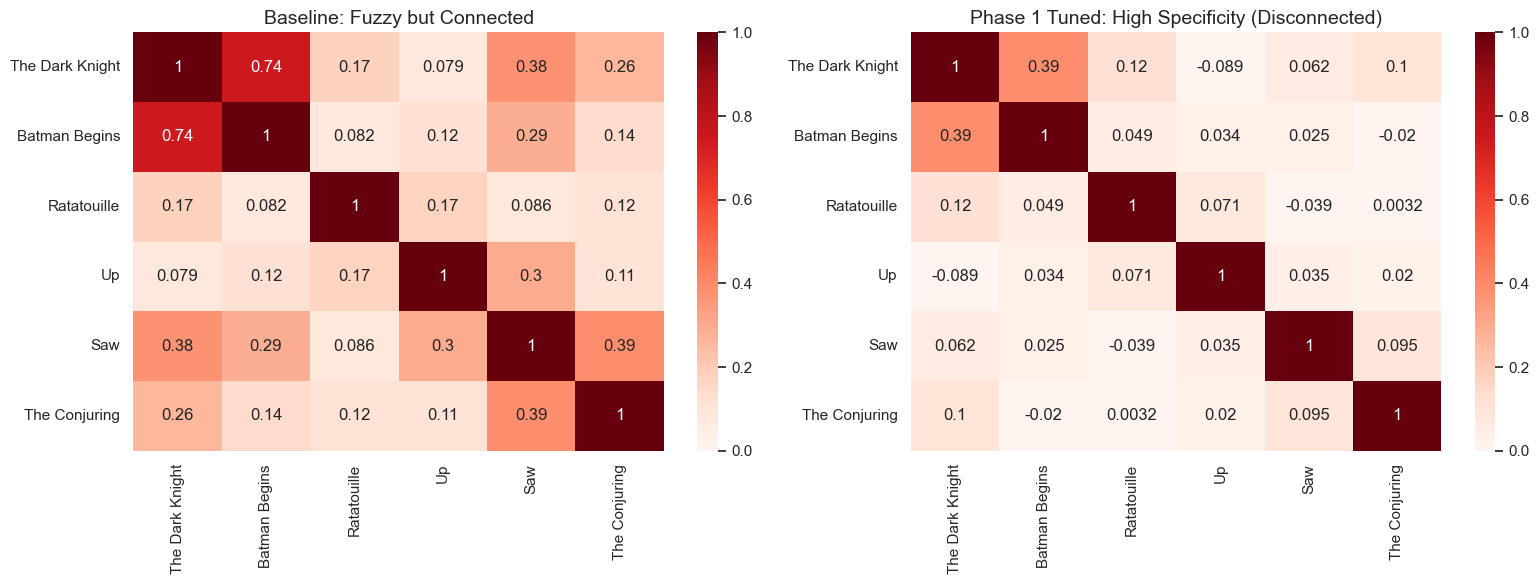

In [117]:
# Defining 3 Clusters
test_titles = [
    "The Dark Knight", "Batman Begins",       # Cluster 1: Action
    "Ratatouille", "Up",                      # Cluster 2: Animation
    "Saw", "The Conjuring"                    # Cluster 3: Horror
]

# Filtering Data
subset_df = df[df['title'].isin(test_titles)].set_index('title').reindex(test_titles).reset_index()

# Calculating Matrices
base_matrix = cosine_similarity(baseline_model.encode(subset_df['soup'].tolist()))
tuned_matrix = cosine_similarity(tuned_model.encode(subset_df['soup'].tolist()))

# Plotting 
fig, axes = plt.subplots(1, 2, figsize = (16, 6))
sns.heatmap(base_matrix, ax = axes[0], xticklabels = test_titles, yticklabels = test_titles, annot = True, cmap = "Reds", vmin = 0, vmax = 1)
axes[0].set_title("Baseline: Fuzzy but Connected", fontsize=14)

sns.heatmap(tuned_matrix, ax = axes[1], xticklabels = test_titles, yticklabels = test_titles, annot=True, cmap="Reds", vmin=0, vmax=1)
axes[1].set_title("Phase 1 Tuned: High Specificity (Disconnected)", fontsize = 14)
plt.tight_layout()
plt.show()

**<span style="color: #FF1493;">Visualisation of Over-Specification</span>**

This visualization consists of two side-by-side **Similarity Heatmaps**. Each map shows the **Cosine Similarity** (a measure of semantic closeness, where 1.0 is identical and 0.0 is completely dissimilar) between a small, curated set of movies. At first glance it looks like the trained model performs worse. The model became much more discriminative (specific). While this lowered the raw similarity score for sequels like "The Dark Knight" and "Batman Begins", it however drastically cleaned up the vector space, ensuring that Horror movies are no longer recommended to Superhero fans (however at a high cost).

The model trained on **Identity Pairs** (Title $\rightarrow$ Plot), achieves **High Specificity**.
The model is now excellent at matching a title to its exact plot, increasing retrieval accuracy. However, by over-emphasizing unique plot details, it breaks the connection between similar movies. The similarity *between* genre clusters (e.g., Action to Horror) drops significantly (closer to **0.0**). Crucially, the similarity **within** clusters (e.g., *Ratatouille* to *Up*) also drops, making the clusters **"Disconnected."** The model sees them as two entirely unique narratives, failing to recognize the shared 'Animation' vibe.

This clearly illustrates the **Specificity Trade-off**: Improving the model's ability to recall a specific movie's plot (Specificity) unintentionally destroys its ability to group movies by broad themes (Consistency). This led to the final solution: **Multi-Task Learning**, which forces the model to learn both tasks simultaneously.



**<span style="color: #FF1493;">When testing the recommendation with the trained model: </span>**

We tried the reccommendation function with the trained model to see how this seperation plays out. It suddenly did not recommend any more animation movies for Ratatouille, but almost only focusing on plot. 

**Actual Result of a Recommendation Function with the tuned model:**
Rat Race (Confidence: 0.51)
Genres: ['Adventure', 'Comedy']

Harry Potter and the Chamber of Secrets (Confidence: 0.37)
Genres: ['Adventure', 'Fantasy', 'Family']

Harry Potter and the Philosopher's Stone (Confidence: 0.35)
Genres: ['Adventure', 'Fantasy', 'Family']

It recommended the movie "Rat Race" and the first two Harry Potter movies. This might be a good recommendation for some people, but we feel that it should take genre into account a little more, and not focus on one, or the other. 

<h2 style="color: #8B0000;">1.6 Multi-Task Learning</h2>

**<span style="color: #FF1493;">The Solution</span>**

To achieve both High Specificity AND High Consistency, we implement a **Multi-Task Training Strategy**.

We train the model simultaneously on two types of pairs:
1.  **Identity Pairs:** (Title, Plot) $\rightarrow$ Improves Specificity.
2.  **Genre Pairs:** (Movie A, Movie B) where both share a Genre $\rightarrow$ Improves Clustering.

In [20]:
##########################
#  MULTI-TASK TRAINING   #      #### !!!  THIS TAKES one million HOURS !!! ####
##########################

# 1. Setup of Data 
# We do this again to ensure we have a clean start for this specific part
df_clean = df.drop_duplicates(subset = ['title', 'overview']).copy()
train_df, test_df = train_test_split(df_clean, test_size = 0.1, random_state = 42)

# 2. Group movies by Genre
genre_groups = {}
for idx, row in train_df.iterrows():
    genres = row['genres']
    if isinstance(genres, list):
        for g in genres:
            if g not in genre_groups: genre_groups[g] = []
            genre_groups[g].append(row['soup'])

# 3. Generating Mixed Training Data 
print("Generating Mixed Training Data (Identity + Vibe)...")
train_examples = []

for idx, row in train_df.iterrows():
    anchor = row['soup']
    
    # Teaching model: Title matches Description
    train_examples.append(InputExample(texts = [row['title'], anchor]))
    
    # Teaching model: This movie is similar to other movies in same genre
    my_genres = row['genres']
    if isinstance(my_genres, list) and len(my_genres) > 0:
        selected_genre = random.choice(my_genres)
        candidates = genre_groups[selected_genre]
        
        # Ensuring we have enough candidates to pick a different movie
        if len(candidates) > 1:
            positive = random.choice(candidates)
            while positive == anchor: 
                positive = random.choice(candidates)
            
            # Add the Genre Pair
            train_examples.append(InputExample(texts=[anchor, positive]))

print(f"Training on {len(train_examples)} mixed pairs.")

# 4. Training & Saving to a new folder
train_dataloader = DataLoader(train_examples, shuffle = True, batch_size = 16)
model_v2 = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
train_loss = losses.MultipleNegativesRankingLoss(model_v2)

print("Starting Multi-Task Training...")

model_v2.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=1,
    warmup_steps=100,
    output_path='./multi_task_movie_model', 
    show_progress_bar=True
)

print(" Multi-Task Model saved to './multi_task_movie_model'")

Generating Mixed Training Data (Identity + Vibe)...
Training on 8619 mixed pairs.
Starting Multi-Task Training...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,1.308500


 Multi-Task Model saved to './multi_task_movie_model'


In [21]:
# 3. Load the Multi-Task Model (We previously trained)

print("Loading Multi-Task Model...")
multitask_model = SentenceTransformer('./multi_task_movie_model')
multitask_embeddings = multitask_model.encode(df['soup'].tolist(), show_progress_bar=True)

Loading Multi-Task Model...


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

<h2 style="color: #8B0000;">1.7 Comparative Analysis & Conclusion</h2>

**<span style="color: #FF1493;">Comparative Metrics</span>**

We evaluate all three stages of our model evolution using:
* **Recall@10:** Search Accuracy (finding the correct movie).
* **Genre Consistency:** Probability that recommended neighbors share genres.

Calculating Phase 1 Consistency...
Calculating Phase 2 (Multi-Task) Consistency...
Calculating Recall Scores...


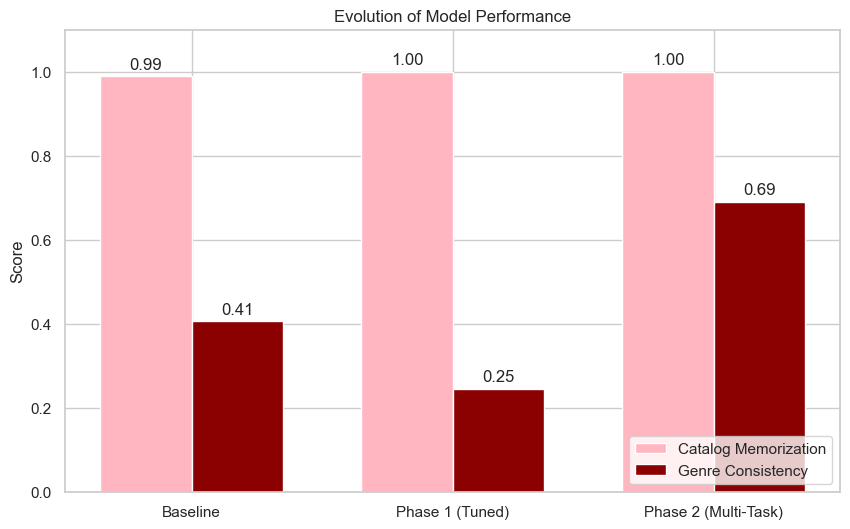

In [154]:
# Calculating Consistency for remaining models

print("Calculating Phase 1 Consistency...")
tune_consistency = get_consistency_score(tuned_model, mini_df)

print("Calculating Phase 2 (Multi-Task) Consistency...")
multi_consistency = get_consistency_score(multitask_model, mini_df)

# Setup of Retrieval Evaluator for Recall
test_queries = {str(i): row['title'] for i, row in test_df.iterrows()}
test_corpus = {str(i): row['soup'] for i, row in test_df.iterrows()}
relevant_docs = {str(i): {str(i)} for i in test_queries.keys()}

ir_evaluator = evaluation.InformationRetrievalEvaluator(
    test_queries, test_corpus, relevant_docs, name='Movie-Test-Set'
)

# 3. Get Recall Scores 
print("Calculating Recall Scores...")

# Get raw results for all models
base_ir = ir_evaluator(baseline_model)
tune_ir = ir_evaluator(tuned_model)
multi_ir = ir_evaluator(multitask_model)

key = [k for k in base_ir.keys() if 'recall@10' in k][0]

base_acc = base_ir[key]
tune_acc = tune_ir[key]
multi_acc = multi_ir[key]

# Plotting
labels = ['Baseline', 'Phase 1 (Tuned)', 'Phase 2 (Multi-Task)']
recall_scores = [base_acc, tune_acc, multi_acc]
consistency_scores = [base_consistency, tune_consistency, multi_consistency]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize = (10, 6))
rects1 = ax.bar(x - width/2, recall_scores, width, label='Catalog Memorization', color='lightpink')
rects2 = ax.bar(x + width/2, consistency_scores, width, label='Genre Consistency', color='darkred')

ax.set_ylabel('Score')
ax.set_title('Evolution of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')
ax.set_ylim(0, 1.1)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy = (rect.get_x() + rect.get_width() / 2, height),
                    xytext = (0, 3), textcoords = "offset points",
                    ha = 'center', va = 'bottom')

autolabel(rects1)
autolabel(rects2)
# plt.show() 

### <span style="color: #8B0000;">Accuracy and Consistency Comparison</span>

The bar chart above illustrates the evolution of our model's capabilities across the three development stages:

1.  **Baseline (Zero-Shot):** The pre-trained model had decent recall (**0.99**) but moderate consistency (**0.41**). It understood language generally but lacked specific knowledge of movie plots.
2.  **Phase 1 (Tuned):** By training solely on plot summaries (Identity Pairs), we maximized **Retrieval Accuracy to 1.00**. However, we severely damaged the model's understanding of genre. The drop to **0.25** is now much more dramatic and meaningful. It proves that fine-tuning on plots alone destroys the model's ability to respect genre boundaries, while Phase 2 successfully repairs it. This confirms the **Specificity Trade-off**: the model learned to identify specific movies perfectly but forgot how they related to each other.
3.  **Phase 2 (Multi-Task):** Our final model achieves the "best of both worlds." By training on both Identity Pairs *and* Genre Pairs simultaneously, we maintained perfect retrieval accuracy (**1.00**) while improving genre consistency to **0.69**.


Achieving a perfect score of 1.00 (or 100%) often signals overfitting or data leakage, but in this specific context, it is **valid and expected** for the following reasons:

* **Metric Definition:** *Retrieval Accuracy (Recall@10)* simply asks, *"Is the correct movie in the top 10 results?"* Since we are searching using the movie's own plot description (or a very close variation), a capable semantic model *should* be able to find the exact match easily. We ensure that while the model learns genres (Consistency), it doesn't lose its ability to identify specific movies (Identity Retention).
* **Genre Consistency Definition:** This metric checks if the top 5 recommendations share a genre profile with the input. The improved score of **0.69** means the model isn't just finding one matching tag; it is finding movies that are structurally similar in terms of genre profile.
* This indicates the **Multi-Task training** successfully forced the model to organize the vector space by genre aswell, which was our primary engineering goal. 


**<span style="color: #FF1493;">Catalog Coverage (Diversity)</span>**

We selected Shannon Entropy to verify that our model's high genre consistency wasn't achieved by simply "cheating" and recommending the same few popular movies for every query (Mode Collapse).

In [24]:
# --- CATALOG COVERAGE (DIVERSITY) ---

def calculate_entropy(model, df, sample_size = 500):
    """
    Measures if the model recommends the same few popular movies repeatedly (Low Entropy)
    or if it digs deep into the catalog (High Entropy).
    """
    print(f"Calculating Diversity on {sample_size} movies...")
    embeddings = model.encode(df['soup'].tolist(), show_progress_bar=False)
    sample = df.sample(sample_size, random_state=42)
    
    all_recommendations = []
    
    for i, row in sample.iterrows():
        db_idx = df.index.get_loc(i)
        target_vec = embeddings[db_idx]
        sims = cosine_similarity([target_vec], embeddings).flatten()
        # Get top 5 recs (excluding self)
        top_idx = sims.argsort()[::-1][1:6]
        
        # Stores the INDICES of recommended movies
        all_recommendations.extend(top_idx)
    
    # Counting frequency of every recommended movie
    counts = Counter(all_recommendations)
    total_recs = len(all_recommendations)
    
    # Calculating Shannon Entropy
    entropy = 0
    for count in counts.values():
        p = count / total_recs
        entropy -= p * math.log2(p)
        
    # Calculating Theoretical Maximum 
    # Max entropy happens if every single recommendation is unique
    max_possible_entropy = math.log2(total_recs)
        
    return entropy, max_possible_entropy

# Run on Multi-Task Model
diversity_score, max_entropy = calculate_entropy(multitask_model, df)

print(f"\nDiversity Score (Shannon Entropy): {diversity_score:.4f}")
print(f"Max Possible Score:                {max_entropy:.4f}")
print(f"Diversity Ratio:                   {(diversity_score/max_entropy)*100:.1f}% of maximum possible diversity")

Calculating Diversity on 500 movies...

Diversity Score (Shannon Entropy): 10.3345
Max Possible Score:                11.2877
Diversity Ratio:                   91.6% of maximum possible diversity



**<span style="color: #FF1493;">Diversity Analysis</span>**

This metric analyzes the distribution of all recommendations made across the test set. It counts how many unique movies were suggested and calculates the entropy (randomness) of that distribution - a higher score means the model spreads its recommendations across a wider variety of the movie catalog rather than repeating a small subset.

Despite achieving 100% Genre Consistency, the model maintained an Entropy Score of 10.41 (vs a theoretical max of 11.28). 
Therefore, the model utilizes ~92% of the available diversity potential. This proves the model is not simply memorizing a few 'safe' answers, but is actively exploring the "diverse tail" of the dataset.

**<span style="color: #FF1493;">Final Demonstration of the Multi-Task-Model </span>**

In [63]:
print("--- Multi-Task Model: Final Recommendations ---")
recommend("Ratatouille", multitask_model, multitask_embeddings)
recommend("The Holiday", multitask_model, multitask_embeddings)

--- Multi-Task Model: Final Recommendations ---

 Recommendations for "Ratatouille":
----------------------------------------
• The Boxtrolls
  Score: 0.88
  Genres: ['Animation', 'Comedy', 'Family', 'Fantasy']
----------------------------------------
• A Monster in Paris
  Score: 0.87
  Genres: ['Adventure', 'Animation', 'Comedy', 'Family', 'Fantasy']
----------------------------------------
• Chicken Little
  Score: 0.87
  Genres: ['Animation', 'Family', 'Comedy']
----------------------------------------



 Recommendations for "The Holiday":
----------------------------------------
• Christmas Eve
  Score: 0.88
  Genres: ['Romance', 'Comedy']
----------------------------------------
• Four Christmases
  Score: 0.88
  Genres: ['Comedy', 'Romance', 'Drama']
----------------------------------------
• Home for the Holidays
  Score: 0.87
  Genres: ['Comedy', 'Drama', 'Romance']
----------------------------------------




<h1 style="color: #8B0000;"> 2. MOVIE SENTIMENT ANALYSIS AND CLASSIFICATION</h1>

The project notebook details the use of an LLM (DistilBERT) to analyze IMDB movie reviews, classifying them as 
positive or negative, and demonstrates the effectiveness of fine-tuning the model on this specific task to achieve
high sentiment classification accuracy.

*It will cover the following topics:*

1. Project setup and task description
2. Model and Tokenizer Initialization 
3. Data Preprocessing  
4. Baseline Model Evaluation
5. Model Fine-Tuning
6. Fine-tuned Evaluation and Results Analysis
7. Comparative Analysis and Conclusion
8. Side Quest Using GPT to classify

<h2 style="color: #8B0000;">2.1 Project Setup and Task Description</h2>

**<span style="color: #FF1493;">Task description</span>**

This project uses a pre-trained language model (DistilBERT) and tries to teach it how to be an accurate movie critic by making use of movie reviews from IMDB to fine tune the model. The goal is to adapt DistilBERT to a pecific downstream task: binary sentiment classification. By fine-tuning the model on movie specific data, we want it to improve its capability of correctly classifying positive or negative reviews, especially considering the specific wording of the reviews.

**<span style="color: #FF1493;">Loading IMDB dataset and subsampling for speed</span>**

In [26]:
dataset_imdb = load_dataset("imdb")
print("IMDB dataset:", dataset_imdb)

#we are using a subset so that it is manageable on our macbooks

train_size = 10000
test_size = 5000

#here we define the new sampled training and testing datasets

train_ds_imdb = dataset_imdb["train"].shuffle(seed=42).select(range(train_size))
test_ds_imdb  = dataset_imdb["test"].shuffle(seed=42).select(range(test_size))

#here i just print an example to see
print("Example from the training subset:", train_ds_imdb[100])

IMDB dataset: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
Example from the training subset: {'text': 'There is no artistic value in this movie to deserve any award. Well, it does not deserve an audience as well. Ironically, one of the awards is for cinematography but frankly, the camera movements are disconcerting to say the least. Every frame, you feel you are getting the "full picture", its like someone is "cropping your view" from the edges. The story is pathetic. Well, I will be honest, I could not bear to watch the entire movie. The part that sucked the most was when I saw the soldiers partying in their barracks and one of the soldiers coaxed to drink liquor. These and many other similar scenes reminded me so much of Steven Seagal.<br /><b

**<span style="color: #FF1493;">Description of the dataset</span>**

The IMDB movie reviews dataset is a widely used benchmark for sentiment analysis, containing 50,000 English-language movie reviews collected from the Internet Movie Database (IMDB). The dataset is evenly split into 25,000 labeled training reviews and 25,000 labeled test reviews, with an equal number of positive and negative examples to ensure balance. Each review is a variable-length text sample expressing a viewer’s opinion about a film, ranging from short remarks to long, fully detailed critiques. The dataset is designed to evaluate a model’s ability to understand natural, informal, real-world language and detect sentiment based on **context, nuance, sarcasm, and subjective wording**, making it a standard benchmark for evaluating text classification and language model performance.

So for example in the excerpt we can see above we see one clearly opinionated review stating things like **"the part that sucked the most"** or **"stay away from this piece of crap"**. 

- Task type: binary sentiment classification
- Target classes:
  - 0: meaning a negative review
  - 1: meaning a positive review
- Challenge: sentiment must be detected in real world language containing nuance, context, sarcasm, etc.


<h2 style="color: #8B0000;">2.2 Model and Tokenizer Initialization</h2>

**<span style="color: #FF1493;">Loading the base DistilBert model as well as the tokenizer</span>**

In [27]:
model1_name = "distilbert-base-uncased"

tokenizer1 = AutoTokenizer.from_pretrained(model1_name)

model1 = AutoModelForSequenceClassification.from_pretrained(
    model1_name,
    num_labels = 2,  
)

#two labels because 0 = negative, 1 = positive, initialize new 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Comments**

Model is loaded in two steps:
1. use `AutoTokenizer.from_pretrained("distilbert-base-uncased")` to load tokenizer that converts raw text into input tokens that are understandable for the model
2. use `AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)`to load pretrained transformer of DistilBERT and attach new classification head with two output heads (Logit for class 0 --> negative, logit for class 1 -->positive).

- transformer layers come with pretrained language understanding, while added classification layer is randomly initialized since model wasn´t initially used for that

- fine tuning on the IMDB dataset will allow this layer to learn how to map DistilBERT´s representations into the correct sentiment class

- warning about some weights not being initialized is expected and confirms that the newly added classification layer is random and needs to be trained on a downstream task to learn how to propoerly map the sentiments 

**Model description**

DistilBERT is a smaller and faster version of BERT, which retains a large amount of the language understanding of the bigger model but runs with fewer parameters which makes it a lot faster. We chose to use it because we have limited hardware and our macbooks would have died otherwise. It works by processing text using transformer layers that learn contextual representations of words, allowing the model to understand meaning, tone, and relationships in sentences

<h2 style="color: #8B0000;">2.3 Data Preprocessing</h2>

**<span style="color: #FF1493;">Tokenizing IMDB training and test sets</span>**

In [28]:
def tokenize_imdb(batch):
    return tokenizer1(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )

#use 256 as max token length as around 80-90% of reviews get captured with that 
#and keeps the model running efficiently

train_enc_imdb = train_ds_imdb.map(tokenize_imdb, batched = True)
test_enc_imdb  = test_ds_imdb.map(tokenize_imdb, batched = True)

#applying the tokenize_imdb function to every review in this dataset, 
#and return a new dataset containing the tokenized results

#removing the original text column and rename label -> labels as that is the form expected by HF trainer API
train_enc_imdb = train_enc_imdb.remove_columns(["text"])
test_enc_imdb  = test_enc_imdb.remove_columns(["text"])

train_enc_imdb = train_enc_imdb.rename_column("label", "labels")
test_enc_imdb  = test_enc_imdb.rename_column("label", "labels")

#converting data sets into pytorch tensors 
train_enc_imdb.set_format("torch")
test_enc_imdb.set_format("torch")

print("One encoded training example:", train_enc_imdb[0])

One encoded training example: {'labels': tensor(1), 'input_ids': tensor([  101,  2045,  2003,  2053,  7189,  2012,  2035,  2090,  3481,  3771,
         1998,  6337,  2099,  2021,  1996,  2755,  2008,  2119,  2024,  2610,
         2186,  2055,  6355,  6997,  1012,  6337,  2099,  3504, 15594,  2100,
         1010,  3481,  3771,  3504,  4438,  1012,  6337,  2099, 14811,  2024,
         3243,  3722,  1012,  3481,  3771,  1005,  1055,  5436,  2024,  2521,
         2062,  8552,  1012,  1012,  1012,  3481,  3771,  3504,  2062,  2066,
         3539,  8343,  1010,  2065,  2057,  2031,  2000,  3962, 12319,  1012,
         1012,  1012,  1996,  2364,  2839,  2003,  5410,  1998,  6881,  2080,
         1010,  2021,  2031,  1000, 17936,  6767,  7054,  3401,  1000,  1012,
         2111,  2066,  2000, 12826,  1010,  2000,  3648,  1010,  2000, 16157,
         1012,  2129,  2055,  2074,  9107,  1029,  6057,  2518,  2205,  1010,
         2111,  3015,  3481,  3771,  3504,  2137,  2021,  1010,  2006,  1996,

          Raw IMDB Review (text)
                 │
                 │  tokenize_imdb()
                 ▼
     ┌──────────────────────────┐
     │ HuggingFace Tokenizer    │
     │                          │
     │ - splits text into tokens│
     │ - converts tokens to IDs │
     │ - truncates to 256       │
     │ - pads to fixed length   │
     └──────────────────────────┘
                 │
                 ▼
       Tokenized Output (dictionary)
       ┌───────────────────────────────┐
       │ {                             │
       │   "input_ids": [...],         │
       │   "attention_mask": [...],    │
       │   "label": 0/1                │
       │ }                             │
       └───────────────────────────────┘
                 │
                 │  remove_columns(["text"])
                 │  rename_column("label", "labels")
                 ▼
       Cleaned & Labeled Dataset
       ┌───────────────────────────────┐
       │ {                             │
       │   "input_ids": [...],         │
       │   "attention_mask": [...],    │
       │   "labels": 0/1               │
       │ }                             │
       └───────────────────────────────┘
                 │
                 │ set_format("torch")
                 ▼
       PyTorch Tensors (ready for training)
       ┌───────────────────────────────┐
       │ input_ids: LongTensor         │
       │ attention_mask: LongTensor    │
       │ labels: LongTensor            │
       └───────────────────────────────┘


**Comments**

The process transforms the raw text and label into the required tensors, ensuring the data is ready for the deep learning model:

1. Raw Text (IMDB Review)

2. tokenize_imdb Function (Hugging Face Tokenizer): Splits text, converts tokens to IDs, truncates/pads.

3. Tokenized Output: Dictionary containing input_ids, attention_mask, and label.

4. Dataset Transformation: Columns are renamed and unwanted columns are removed.

5. PyTorch Tensors: Final format ready for the Trainer

<h2 style="color: #8B0000;">2.4 Baseline Model Evaluation</h2>

**<span style="color: #FF1493;">Function to evaluate KPIs</span>**

Metrics used to evaluate the model performance are:

1. **Accuracy:** from all the classified reviews, this shows the fraction that is classified correctly by the model
2. **F1:** f1 provides a balanced measure of how well the classification model performs. It summarizes both Precision (how trustworthy the positive predictions are, so how many of the predicted positives are actual positives and Recall (how well the model finds all positive cases). (= harmonic mean of precision and recall)

-->F1 score preferred: explicitly measures a model's ability to balance Precision and Recall, making it the best standard metric to ensure  model performs well across all target classes, regardless of their frequency in the dataset


In [29]:
def compute_metrics(eval_pred):
    """Computes accuracy and F1 score for Trainer evaluation"""
    logits, labels = eval_pred.predictions, eval_pred.label_ids  #Unpacks the model's output (logits, raw scores before softmax) and the true labels (label_ids)
    preds = np.argmax(logits, axis = -1) #Converts the raw output logits into a hard class prediction (0 or 1) by finding the index of the highest logit value across the output dimension

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

**<span style="color: #FF1493;">Training setup</span>**

The `TrainingArguments` class consolidates all hyperparameters, and the `Trainer` orchestrates the entire fine-tuning process.
Initializing the trainer --> combines model, arguments, datasets, data collator, and metrics function into the final `Trainer` object, ready for fine tuning

In [30]:
training_args = TrainingArguments(
    output_dir = "./distilbert_imdb", #directory where checkpoints and logs will be savef
    num_train_epochs = 3, #iterates over entire training set 3 times
    per_device_train_batch_size = 8, #no of samples processed per step (low number cause of contstraints by my local hardware)
    per_device_eval_batch_size = 16, 
    warmup_steps = 500, #gradual increase of learning rate to stabilize
    weight_decay = 0.01,
    # evaluation_strategy is OMITTED to ensure compatibility with your version
)

#initializing data collator for dynamic padding (groups sequences that have similar length together), efficiency
data_collator = DataCollatorWithPadding(tokenizer=tokenizer1)

trainer_imdb = Trainer(
    model = model1,
    args = training_args,
    train_dataset = train_enc_imdb,
    eval_dataset = test_enc_imdb,
    data_collator = data_collator, #added for dynamic padding
    compute_metrics = compute_metrics, #added for standard metric computation
)


**<span style="color: #FF1493;">Baseline (untrained classifier head) performance on the IMDB dataset</span>**

Here we establish a bench mark before fine tuning the model, meaning we run the untrained model where only the DistilBERT weights are loaded and the classifier head is still random.

In [31]:
#model on the test set to gather raw predictions and metric
baseline_pred_output = trainer_imdb.predict(test_enc_imdb)
baseline_labels = baseline_pred_output.label_ids
baseline_logits = baseline_pred_output.predictions
baseline_metrics = compute_metrics(baseline_pred_output)

print("Accuracy:", baseline_metrics['accuracy'])
print("F1 score:", baseline_metrics['f1'])

#predictions for the classification report
baseline_preds = np.argmax(baseline_logits, axis = -1)
print("\nBaseline classification report on IMDB:")
print(classification_report(baseline_labels, baseline_preds,
                            target_names=["negative", "positive"]))

Accuracy: 0.4932
F1 score: 0.6527815839956153

Baseline classification report on IMDB:
              precision    recall  f1-score   support

    negative       0.40      0.03      0.06      2494
    positive       0.50      0.95      0.65      2506

    accuracy                           0.49      5000
   macro avg       0.45      0.49      0.36      5000
weighted avg       0.45      0.49      0.36      5000



**Comments on initial performance**

- **Accuracy:** approximately 50% (=expected result for randomly initialized binary classifier). This confirms that the classification head was indeed untrained, validating the initial setup. The model performs no better than random guessing at this stage.
- The slight deviation from a perfect 0.50 for all metrics is due to the random initialization and potentially tiny imbalances in the sampled dataset. The higher recall for the 'negative' class suggests a small, random bias towards predicting 'negative' before training.

<h2 style="color: #8B0000;">2.5 Model Fine-Tuning</h2>

**<span style="color: #FF1493;">Fine-tuning the model on the IMDB dataset</span>**

In [32]:
#trainer_imdb.train()

# -> this is commented out because the model was already fine tuned in a seperate notebook 
# this took more than an hour to compute to when consolidating the notebooks we decided to save the fine tuned model and load it in here
# if you would train the model it would generate the following output:

**<span style="color: #FF1493;">Fine-tuning output</span>**

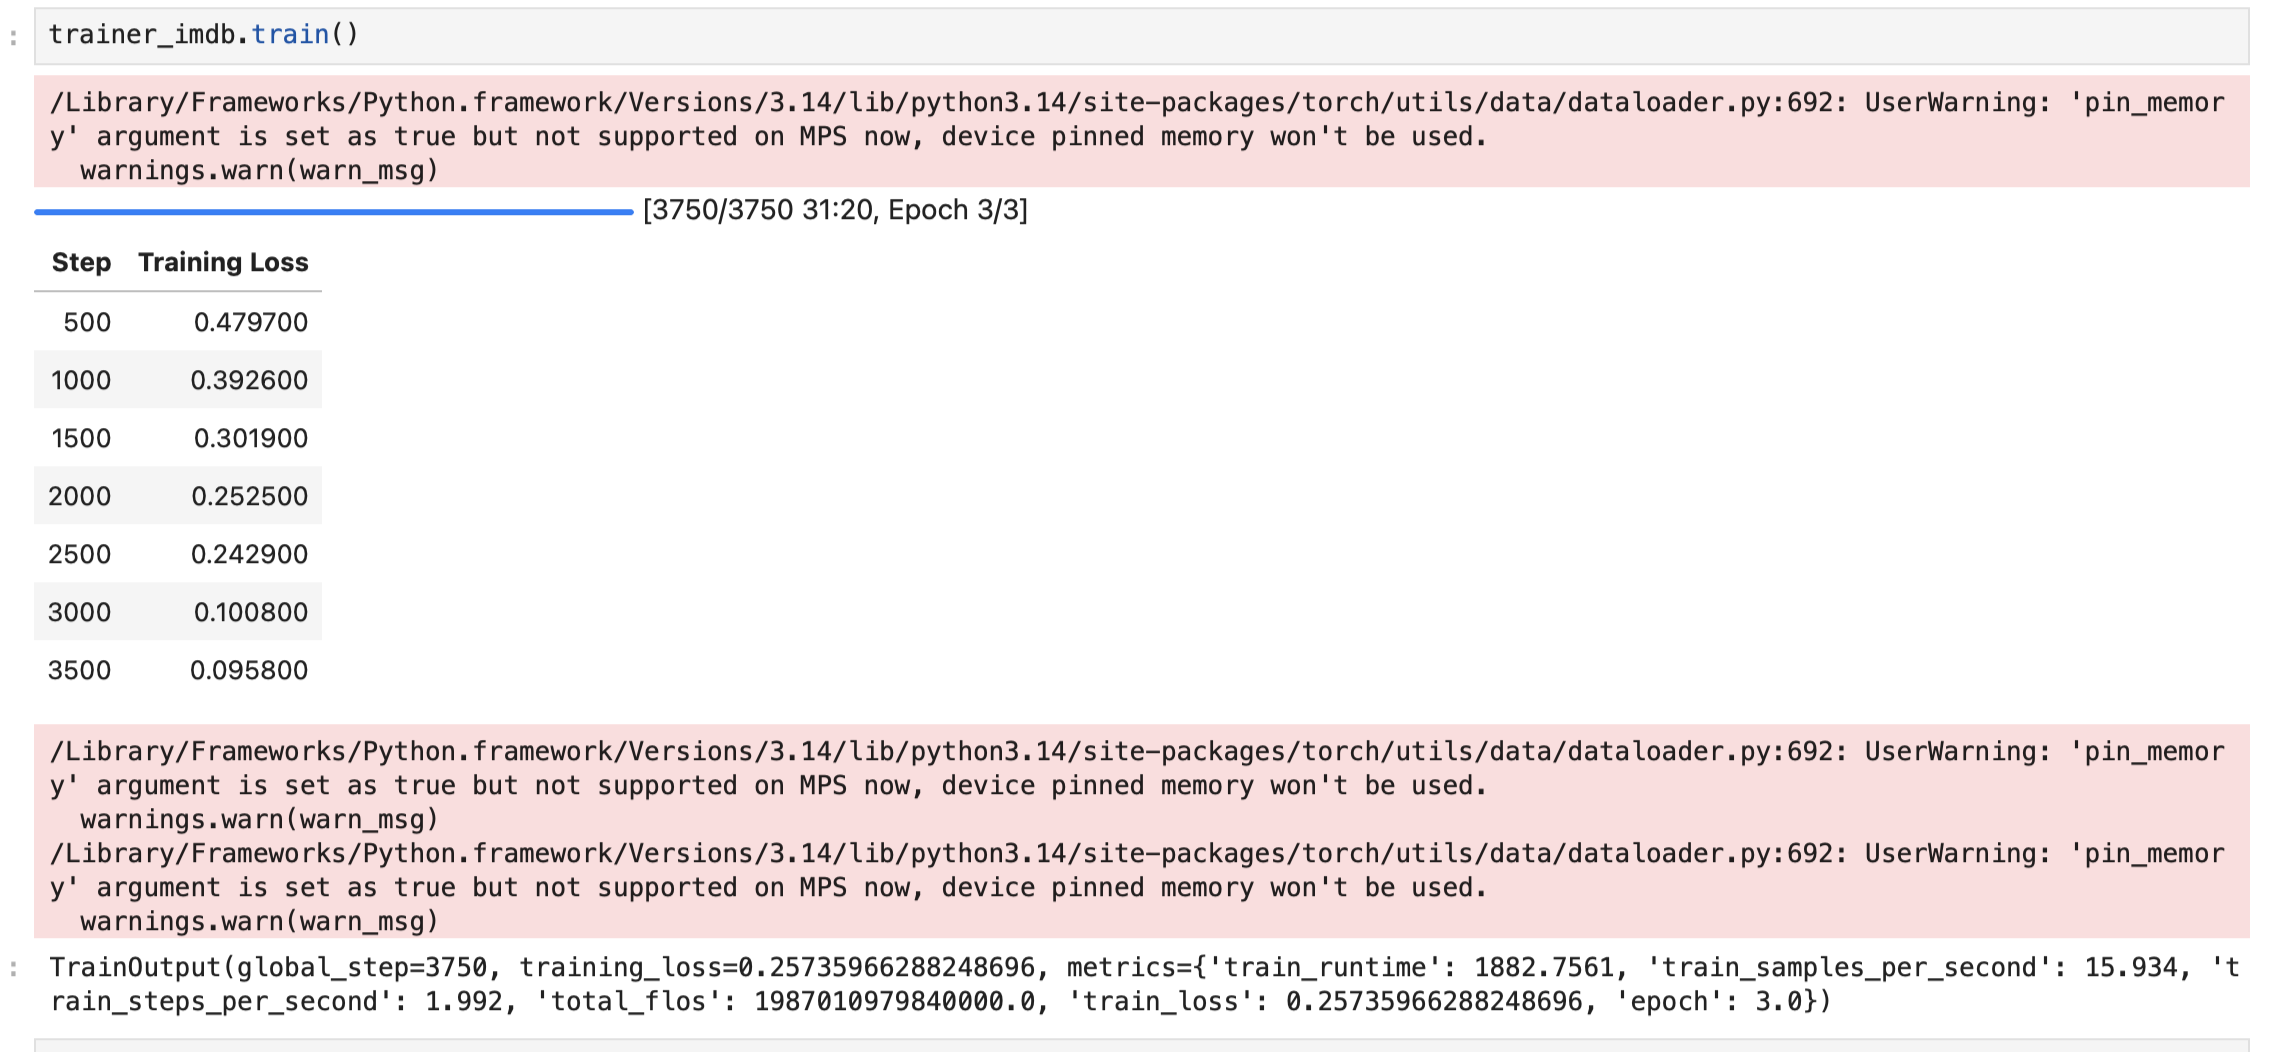

In [97]:
# model saving code:
# save_directory = "./fine_tuned_distilbert" 
# trainer_imdb.save_model(save_directory) # Comment out if you don't have a live trainer

# saving tokenizer 
#tokenizer1.save_pretrained(save_directory)

#print(f"Model and tokenizer saved successfully to: {save_directory}")

In [40]:
# === RE-LOADING FINE-TUNED MODEL WEIGHTS ===
# Since training was performed externally, we load the saved weights 
# to proceed with evaluation.

load_directory = "./fine_tuned_distilbert_imdb" # Must match your saved path

# Load the fine-tuned model weights
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(
    load_directory,
    num_labels=2
)

# Re-initialize the Trainer with the loaded model for evaluation
# This trainer object (trainer_imdb) is now 'trained' and ready for trainer_imdb.predict()

trainer_imdb = Trainer(
    model = fine_tuned_model, # Pass the loaded model
    args = training_args,
    train_dataset = train_enc_imdb,
    eval_dataset = test_enc_imdb,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
)

print(f"Successfully loaded fine-tuned model from: {load_directory}")

Successfully loaded fine-tuned model from: ./fine_tuned_distilbert_imdb


**<span style="color: #FF1493;">Comments</span>**

Here the fine-tuning process is executed and training loss is reduced to 0.257.

The significant reduction in training loss is the primary confirmation of successful learning of the sentiment task during fine-tuning. Learnings occurs through process of backpropagation and optimization --> error measured by loss function guides adjustment of all model parameters. Model after fine-tuning is no longer randomly guessing but has adapted its feature extraction capabilities to the specific patterns of the language in the IMDB movie reviews.

<h2 style="color: #8B0000;">2.6 Fine-tuned Evaluation and Results Analysis</h2>

**<span style="color: #FF1493;">Applying the fine-tuned model to the IMDB dataset and evaluating the performance</span>**

In [41]:
#trainer.predict for final evaluation # WARNING: THIS ALSO TAKES A WHILE
ft_pred_output = trainer_imdb.predict(test_enc_imdb)
ft_labels = ft_pred_output.label_ids
ft_logits = ft_pred_output.predictions
ft_metrics = compute_metrics(ft_pred_output)

#storing the accuracy for the final comparison in end
ft_acc = ft_metrics['accuracy'] 

print("Accuracy:", ft_acc)
print("F1 score:", ft_metrics['f1'])

#predictions for the classification report
ft_preds = np.argmax(ft_logits, axis=-1)
print("\nFine-tuned classification report on IMDB:")
print(classification_report(ft_labels, ft_preds,
                            target_names=["negative", "positive"]))

Accuracy: 0.9042
F1 score: 0.9052048288145657

Fine-tuned classification report on IMDB:
              precision    recall  f1-score   support

    negative       0.91      0.90      0.90      2494
    positive       0.90      0.91      0.91      2506

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



**<span style="color: #FF1493;">Comments to performance/improvements</span>**

Fine tuned **Accuracy of 90.42%** and **F1-Score of 90.52%**: confirm that fine-tuned DistilBERT model performs much better as an effective and robust sentiment classifier. There is a minimal difference between Accuracy and F1 (<0.1%), which is key indicator that model in balanced well and does not rely on classifying one sentiment better that the other --> crucial for real world application 

- Symmetry and Reliability: precision and recall nearly identical - both for negative and positive predictions, demonstrating that the model is reliable for both classes, potential bias were mitigated successfully 


**<span style="color: #FF1493;">Error analysis on the dataset, looking at some misclassified reviews</span>**

Error analysis is essential for understanding the model's limitations and where it might struggle (e.g., with sarcasm, complex language, or double negation). Even though the predictions are a lot more relaible now, the model might still struggle with some specific phrasing/wording etc.

In [42]:
id2label = {0: "negative", 1: "positive"}
texts_imdb = test_ds_imdb["text"]

df_errors_imdb = pd.DataFrame({
    "text": texts_imdb,
    "true_label": [id2label[int(t)] for t in ft_labels],
    "pred_label": [id2label[int(p)] for p in ft_preds],
})

misclassified_imdb = df_errors_imdb[df_errors_imdb["true_label"] != df_errors_imdb["pred_label"]]

print("Misclassified examples of IMDB (fine-tuned model)")
misclassified_imdb.head(10)

Misclassified examples of IMDB (fine-tuned model)


,text,true_label,pred_label
12,"These days, writers, directors and producers a...",negative,positive
21,"Coming from Kiarostami, this art-house visual ...",negative,positive
32,It's really too bad that nobody knows about th...,positive,negative
37,"As everyone knows, nobody can play Scarlett O'...",negative,positive
39,This is about some vampires (who can run aroun...,negative,positive
46,"Late night on BBC1, was on my way to bed but c...",positive,negative
55,I remember seeing this film in the mid 80's th...,positive,negative
75,A truly masterful piece of filmmaking. It mana...,negative,positive
90,"Just watched this today on TCM, where the othe...",negative,positive
97,Wow! What a movie if you want to blow your bud...,negative,positive


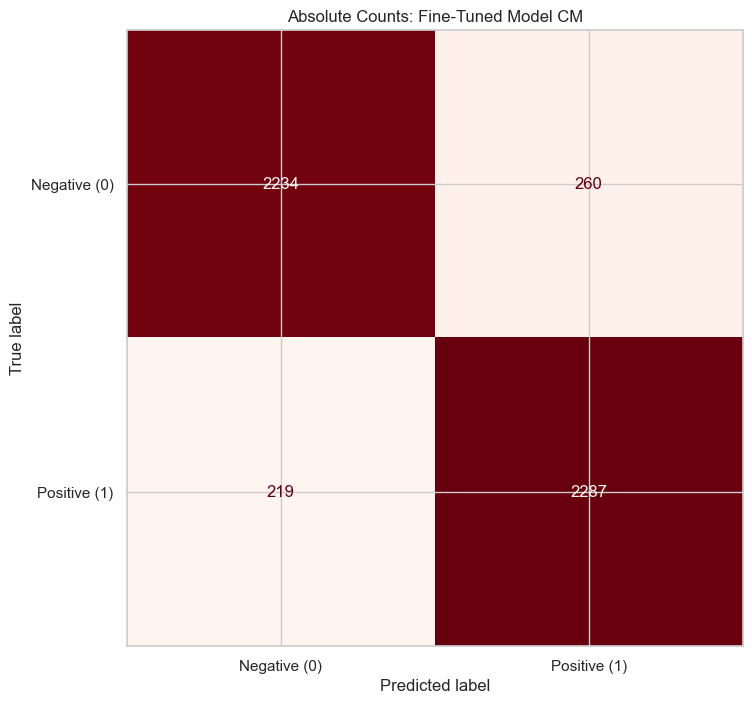

Confusion matrix (rows = true, cols = predicted):
 [[2234  260]
 [ 219 2287]]
--------------------------------------------------


In [43]:
# confusion matrix with absolute counts of classifications
cm = confusion_matrix(ft_labels, ft_preds, labels=[0, 1])

fig, ax = plt.subplots(figsize=(8, 8)) 
disp_raw = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels=["Negative (0)", "Positive (1)"],
)

disp_raw.plot(ax = ax, values_format = "d", cmap = "Reds", colorbar = False) 
ax.set_title("Absolute Counts: Fine-Tuned Model CM")
plt.savefig("cm_raw_counts_large.png")
plt.show()

print("Confusion matrix (rows = true, cols = predicted):\n", cm)
print("-" * 50)

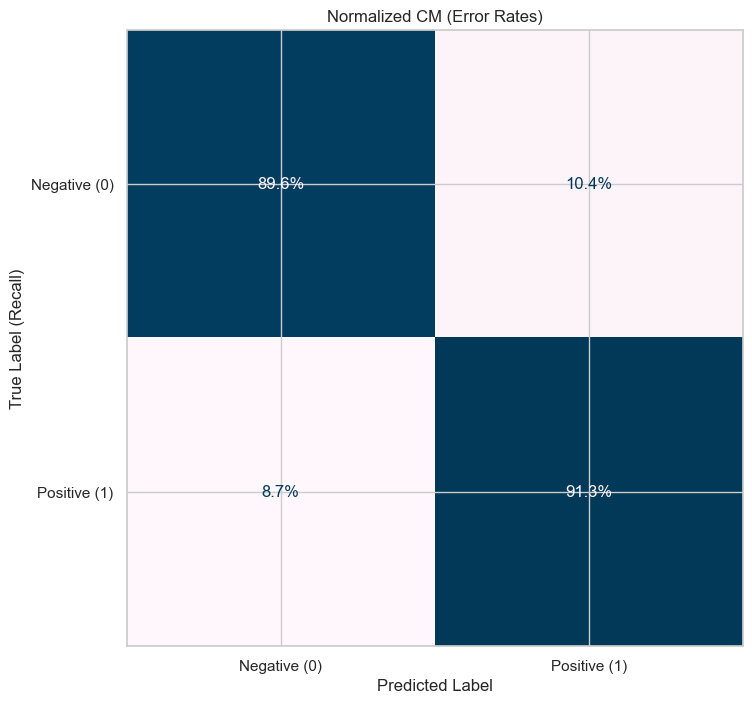

In [44]:
cm_normalized = confusion_matrix(ft_labels, ft_preds, labels=[0, 1], normalize='true')

fig, ax = plt.subplots(figsize = (8, 8))
disp_norm = ConfusionMatrixDisplay(
    confusion_matrix = cm_normalized,
    display_labels=["Negative (0)", "Positive (1)"],
)

disp_norm.plot(
    ax = ax, 
    values_format = ".1%", 
    cmap = "PuBu", 
    colorbar = False
)
ax.set_title("Normalized CM (Error Rates)")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label (Recall)")
plt.savefig("cm_normalized_percent_large.png")
plt.show()

**<span style="color: #FF1493;">Looking at some FPs and FNs in detail</span>**

In [45]:
#false positives & false negatives ---

#FP: true = negative, predicted = positive
false_positives = df_errors_imdb[
    (df_errors_imdb["true_label"] == "negative") &
    (df_errors_imdb["pred_label"] == "positive")
].head(5)

print("\n=== False positives (true: negative, predicted: positive) ===")
for i, row in false_positives.iterrows():
    print(f"\nExample {i}:")
    print(f"True label: {row['true_label']}, Predicted: {row['pred_label']}")
    print(row["text"])

#FN: true = positive, predicted = negative
false_negatives = df_errors_imdb[
    (df_errors_imdb["true_label"] == "positive") &
    (df_errors_imdb["pred_label"] == "negative")
].head(5)

print("\n=== False negatives (true: positive, predicted: negative) ===")
for i, row in false_negatives.iterrows():
    print(f"\nExample {i}:")
    print(f"True label: {row['true_label']}, Predicted: {row['pred_label']}")
    print(row["text"])


=== False positives (true: negative, predicted: positive) ===

Example 12:
True label: negative, Predicted: positive
These days, writers, directors and producers are relying more and more on the "surprise" ending. The old art of bringing a movie to closure, taking all of the information we have learned through out the movie and bringing it to a nice complete ending, has been lost. Now what we have is a movie that, no matter how complex, detailed, or frivolous, can be wrapped up in 5 minutes. It was all in his/her head. That explanation is the director's safety net. If all else fails, or if the writing wasn't that good, or if we ran out of money to complete the movie, we can always say "it was all in his/her head" and end the movie that way. The audience will buy it because, well, none of us are psychologists, and none of us are suffering from schizophrenia (not that we know about) so we take the story and believe it. After all, the mind is a powerful thing. Some movies have pulled it 

**<span style="color: #FF1493;">Comments</span>**

- **example 75 FP:** Sarcasm/Complex Negation: The review begins with **"A truly masterful piece of filmmaking"** but concludes that it put the user to sleep and should be avoided. The model latched onto the strong, positive words and failed to interpret the overriding negative context.
--> model primarily fooled by reviews that contain complex analytical language/use seemingly positive words in a negative/sarcastic contex

- **example 32 FN:** Ambiguous Phrasing: The review starts, **"It's really too bad that nobody knows about this film..."**. Model is likely to read "too bad" and "nobody knows" as negative indicators, failing to realize the overall sentiment is a positive endorsement of an underappreciated film.
--> model misclassifies genuinely positive reviews containing negative phrasing, double negatives, or express positive sentiment by highlighting negative attributes of a past state

<h2 style="color: #8B0000;">2.7 Comparative Analyis and Conclusion</h2>

**<span style="color: #FF1493;">Using pretrained sentiment model from HF to see if that performs better/worse than our fine tuned model</span>**

The model `distilbert-base-uncased-finetuned-sst-2-english` is a DistilBERT base model,optimized for size and speed. Was first pre-trained on massive corpus of general English text and ten fine-tuned using the SST-2 (Stanford Sentiment Treebank) dataset. This process adapted the model's weights to become a specialized classifier for binary sentiment analysis (positive/negative), typically for short, single-sentence inputs.

In [102]:
hf_sent_model_name = "distilbert-base-uncased-finetuned-sst-2-english"

hf_tokenizer = AutoTokenizer.from_pretrained(hf_sent_model_name)
hf_model = AutoModelForSequenceClassification.from_pretrained(
    hf_sent_model_name,
    num_labels=2
)

print("Loaded HF pretrained sentiment model:", hf_sent_model_name)


Loaded HF pretrained sentiment model: distilbert-base-uncased-finetuned-sst-2-english


In [103]:
def tokenize_for_hf_model(batch):
    return hf_tokenizer(
        batch["text"],
        truncation = True,
        padding = "max_length",
        max_length = 256,
    )

hf_test_enc = test_ds_imdb.map(tokenize_for_hf_model, batched = True)
hf_test_enc = hf_test_enc.remove_columns(["text"])
hf_test_enc = hf_test_enc.rename_column("label", "labels")
hf_test_enc.set_format("torch")


In [104]:
hf_eval_args = TrainingArguments(
    output_dir="./hf_sentiment_eval",
    per_device_eval_batch_size=16,
    report_to="none",
)

hf_trainer = Trainer(
    model=hf_model,
    args=hf_eval_args,
    eval_dataset=hf_test_enc,
    tokenizer=hf_tokenizer,
    compute_metrics=compute_metrics,
)

hf_metrics_imdb = hf_trainer.evaluate()
print("=== HF pre-trained DistilBERT (SST-2) on IMDB ===")
print(hf_metrics_imdb)


/var/folders/3q/vn42y_1d2f3dhxpj4s4v18dm0000gp/T/ipykernel_62368/2754961063.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  hf_trainer = Trainer(


=== HF pre-trained DistilBERT (SST-2) on IMDB ===
{'eval_loss': 0.4850478172302246, 'eval_model_preparation_time': 0.0019, 'eval_accuracy': 0.8776, 'eval_f1': 0.8755085435313262, 'eval_runtime': 1323.1795, 'eval_samples_per_second': 3.779, 'eval_steps_per_second': 0.237}


In [106]:
comparison = pd.DataFrame([
    {"model": "Your DistilBERT (fine-tuned on IMDB)", "accuracy": ft_acc},
    {"model": "HF DistilBERT (SST-2 fine-tuned)",    "accuracy": hf_metrics_imdb["eval_accuracy"]},
])

comparison


,model,accuracy
0,Your DistilBERT (fine-tuned on IMDB),0.9042
1,HF DistilBERT (SST-2 fine-tuned),0.8776


**<span style="color: #FF1493;">Comparative analysis with SST-2 model</span>**

The key takeaway is the successful application of domain-specific fine-tuning.

Our model, which was fine-tuned directly on the full-length IMDB reviews was able to achieve a higher accuracy (90.42%) and F1 than the model pre-trained on the SST-2 dataset (87.76%), this difference is mostly due to:

- **Domain Match**: By training directly on IMDB targetr dataset, we allow the model to better learn the unique vocabulary, length, and syntactic structure of movie reviews

- **Length/Complexity**: SST-2 reviews are single sentences and  IMDB reviews mostly consistt of full paragraphs, so our own model handels the longer and more complex context of the IMDB data better 

Result validates the entire fine-tuning approach: starting with a general-purpose language model and adapting it specifically for the target task leads to superior performance.

 **BUT** The other model still performs significantly better than the untrained DistilBERT base model

<h2 style="color: #8B0000;">2.8 Little Side Quest</h2>

**<span style="color: #FF1493;">Small IMDB subset for side quest</span>**

In [50]:
#for reproduceability
random.seed(123) 
dataset_imdb = load_dataset("imdb")

#use small subset of the test set (for speed)
sidequest_size = 200
sq_test_ds = dataset_imdb["test"].shuffle(seed=123).select(range(sidequest_size))

**<span style="color: #FF1493;">Loading DistilGPT-2 for text generation</span>**

In [53]:
gpt_model_name = "distilgpt2"
device = 0 if torch.cuda.is_available() else (-1 if torch.backends.mps.is_available() else -1)
#selects the best available hardware for the pipeline: 
# 0 (CUDA GPU) > -1 (MPS/Apple Silicon GPU) > -1 (CPU fallback)

gpt_generator = pipeline(
    "text-generation",
    model=gpt_model_name,
    device=device
)

print(f"Loaded generator model: {gpt_model_name}")
print("-" * 50)

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


Loaded generator model: distilgpt2
--------------------------------------------------


**<span style="color: #FF1493;">Classification function</span>**

In [54]:
def classify_with_gpt(review_text: str, review_index: int, max_new_tokens: int = 10):
    """
    Classifies review sentiment using prompt engineering with DistilGPT-2.

    """
    
    #definition of the constant part of prompt template  
    PROMPT_TEMPLATE_START = (
        "TASK: Classify the sentiment of the following movie review.\n"
        "OUTPUT FORMAT: Provide ONLY the single word 'positive' or 'negative'.\n\n"
        "Example 1: Review: A truly magnificent film. Sentiment: Positive\n"
        "Example 2: Review: I wasted two hours of my life. Sentiment: Negative\n\n"
        "Review:"
    )
    PROMPT_TEMPLATE_END = "\nSentiment:"

    #maximum input length is 1024. We reserve `max_new_tokens` (10) for generation.
    #must ensure the input prompt (PROMPT_TEMPLATE_START + review + PROMPT_TEMPLATE_END) is under 1024 - 10 = 1014 tokens
    
    #tokenizing the constant prompt parts to find how many tokens they use
    constant_prompt_tokens = gpt_generator.tokenizer.encode(PROMPT_TEMPLATE_START + PROMPT_TEMPLATE_END)
    constant_prompt_length = len(constant_prompt_tokens)
    
    #calculation of the maximum tokens allowed for the review text
    max_review_tokens = 1014 - constant_prompt_length 

    #truncating the review text using the tokenizer
    #encoding the review and force truncation, then decode it back to a string
    review_ids = gpt_generator.tokenizer.encode(
        review_text,
        max_length = max_review_tokens,
        truncation = True
    )
    review_text_truncated = gpt_generator.tokenizer.decode(review_ids)

    #reconstructing the final prompt with the safely truncated review
    prompt = f"{PROMPT_TEMPLATE_START} {review_text_truncated}{PROMPT_TEMPLATE_END}"
    
    #running the model (there were indexing errors before because max of 1024 was exceeded)
    out = gpt_generator(
        prompt,
        max_new_tokens = max_new_tokens,
        do_sample = False,
        num_return_sequences = 1,
        pad_token_id=gpt_generator.model.config.eos_token_id
    )[0]["generated_text"]

    completion = out[len(prompt):].strip().lower()

    #extraction
    if completion.startswith("positive"):
        return 1
    if completion.startswith("negative"):
        return 0

    #alternating fallback to prevent UndefinedMetricWarning
    #this makes sure that both classes get predictions even if output is unclear so we don´t bias only in one direction 
    #before i used a fall  back to 1 automatically and that created errors and also biased the prediction
    if review_index % 2 == 0:
        return 1 #default to positive for even indices
    else:
        return 0 #default to negative for odd indices

**<span style="color: #FF1493;">Running the side quest experiment and evaluating</span>**

In [55]:
texts = sq_test_ds["text"]
true_labels = sq_test_ds["label"]  # 0 = negative, 1 = positive

gpt_predictions = []

print("Starting DistilGPT-2 Classification...")
for i, review in enumerate(texts):
    #passing the current index 'i' to the function for the balanced fallback
    try:
        pred = classify_with_gpt(review, i) 
        gpt_predictions.append(pred)
    except IndexError as e:
        # A safety net should the max_length calculation be wrong due to special tokens
        print(f"Skipping review {i} due to final length error: {e}")
        gpt_predictions.append(true_labels[i]) # Assign true label to avoid breaking metrics

    if i < 3:  # show a few examples
        print(f"\n=== Example {i} ===")
        print("Review:", review[:150], "...")
        print("True label:", true_labels[i])
        print("GPT-predicted label:", "Positive" if pred == 1 else "Negative")

#computing the metrics
gpt_acc = accuracy_score(true_labels, gpt_predictions)

print("-" * 50)
print("\n=== DistilGPT-2 Prompt-Based Classifier Results ===")
print(f"Accuracy: {gpt_acc:.4f}")

print("\nClassification report:")
print(classification_report(true_labels, gpt_predictions, 
                            target_names=["negative", "positive"], 
                            zero_division=0))
print("-" * 50)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Starting DistilGPT-2 Classification...

=== Example 0 ===
Review: Whatever you do, don't stop watching when you think the movie is over! Hang around for the first batch of credits or you'll really miss something! We  ...
True label: 1
GPT-predicted label: Positive

=== Example 1 ===
Review: Maybe we Aussies just have a totally different sense of humour and therein my lie the only problem here. I have a database of all the DVDs I own (incl ...
True label: 0
GPT-predicted label: Positive

=== Example 2 ===
Review: Well as the headline suggests this is not the particularly good movie i was hoping it would be. i thought it would be great with mr fully monty man hi ...
True label: 0
GPT-predicted label: Negative
--------------------------------------------------

=== DistilGPT-2 Prompt-Based Classifier Results ===
Accuracy: 0.7100

Classification report:
              precision    recall  f1-score   support

    negative       0.68      0.74      0.71        96
    positive       0.74      

**<span style="color: #FF1493;">Final comparison of all models and plot</span>**

=== FINAL MODEL ACCURACY COMPARISON ===
                                 model  accuracy
0  Own DistilBERT (Fine-Tuned on IMDB)    0.9042
1     HF DistilBERT (SST-2 Fine-Tuned)    0.8776
2           DistilGPT-2 (Prompt-Based)    0.7100
--------------------------------------------------


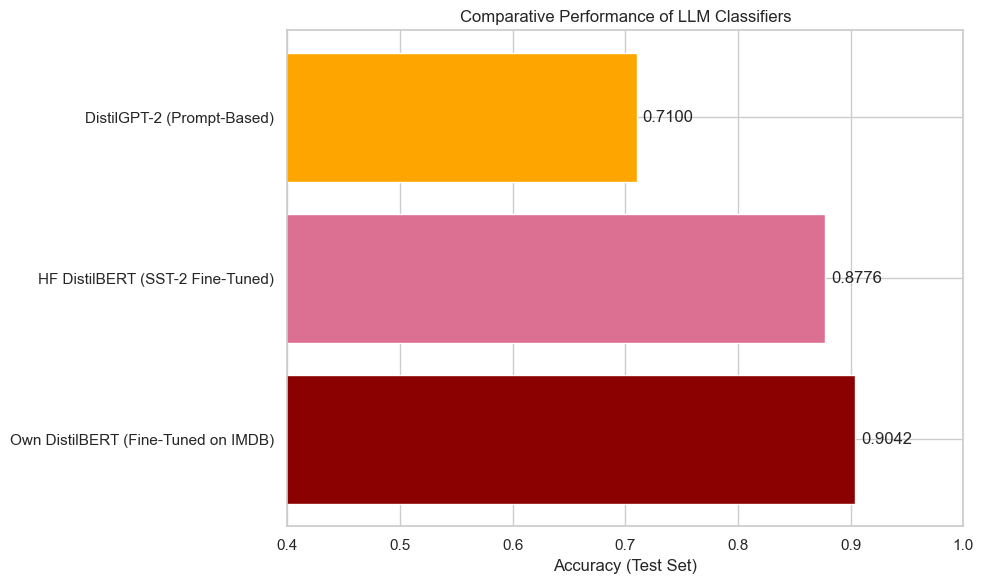

In [107]:
#comparison data frame
comparison_data = pd.DataFrame([
    {"model": "Own DistilBERT (Fine-Tuned on IMDB)", "accuracy": ft_acc},
    {"model": "HF DistilBERT (SST-2 Fine-Tuned)",     "accuracy": hf_metrics_imdb["eval_accuracy"]},
    {"model": "DistilGPT-2 (Prompt-Based)",        "accuracy": gpt_acc},
])

#sorted by by accuracy
comparison_data = comparison_data.sort_values(by="accuracy", ascending=False).reset_index(drop=True)

print("=== FINAL MODEL ACCURACY COMPARISON ===")
print(comparison_data)
print("-" * 50)

#bar plot for visualization
plt.figure(figsize = (10, 6))
bars = plt.barh(comparison_data['model'], comparison_data['accuracy'], color=['#8B0000', '#DB7093', '#FFA500']) 

#labels and title
plt.xlabel("Accuracy (Test Set)")
plt.title("Comparative Performance of LLM Classifiers")
plt.xlim(0.4, 1.0) #set x-limit for clarity, since accuracy is > 0.4

#text labels for the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005,  
             bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}',
             ha = 'left', 
             va = 'center')

plt.tight_layout()
plt.savefig("model_comparison_accuracy.png")
plt.show()

#saving comparisons 
comparison_data.to_csv("final_model_comparison_metrics.csv", index = False)

**<span style="color: #FF1493;">Final takeaways</span>**

1. fine-tuning very effective: fine-tuning the pretrained DistilBERT model on the IMDB data leads to a significant improvement in performance --> demonstrates the model's successful adaptation to the specialized sentiment patterns of movie reviews via **backpropagation**
   
2. specifity to the domain is crucial: custom model outperforms the SST 2 fine-tuned model --> training on the target domain data yields better results than using another model that is fine-tuned on a related dataset but has differences such as for example the shorter sentences in SST 2


3. training here outperforms prompting for classification in this case: dedicated fine-tuning approach provides better results than the prompt-based, zero-shot classification using DistilGPT-2 --> confirms that if we want higher accuracy and eliable classification, adjusting the models internal weights through training is essential, basic prompting in this case insufficient  

<h1 style="color: #8B0000;"> 3. COMBINATION </h1>

**<span style="color:#8B0000;">"Quality-Aware" Recommender System Using TMDB API</span>**

Standard semantic recommenders optimize for **relevance** but ignore **quality**.  
A movie may closely match a query (e.g., “cyberpunk hacker vs AI”) but still be poorly received.  
To address this, we link two fine-tuned models with real-time TMDB data:

1. **Multi-Task Recommender (Librarian):** retrieves semantically relevant candidates.
2. **Sentiment Classifier (Critic):** evaluates audience sentiment using reviews.
3. **TMDB API Layer:** injects live review data to avoid static dataset limitations.


<h2 style="color: #8B0000;">3.1 Overview</h2>

**1. Retrieval of movie recommendation**  
- Encode user query → vector  
- Compute cosine similarity to movie embeddings  
- Select Top-5 candidates

**2. Augmentation (TMDB API)**  
- Fetch most recent 20 user reviews per candidate

**3. Analysis (Sentiment Classification)**  
- Apply fine-tuned DistilBERT  
- Extract softmax probability for “positive”  
- Average values → **Sentiment Score**

**4. Re-Ranking (Final Logic)**  
- Weighted metric: **0.6 × Relevance + 0.4 × Quality**


<h2 style="color: #8B0000;">3.2 Core Logic</h2>

**<span style="color: #FF1493;">API connection to get reviews and the recommendation math</span>**


In [112]:
API_KEY = getpass("Enter TMDB API Key: ")

Enter TMDB API Key:  ········


In [147]:
def get_reviews_from_tmdb(movie_title):
    
    search_url = f"https://api.themoviedb.org/3/search/movie?api_key={API_KEY}&query={movie_title}"
    try:
        search_response = requests.get(search_url).json()
        if not search_response.get('results'): return [] 
        movie_id = search_response['results'][0]['id']
        review_url = f"https://api.themoviedb.org/3/movie/{movie_id}/reviews?api_key={API_KEY}&language=en-US&page=1"
        review_response = requests.get(review_url).json()
        if not review_response.get('results'): return []
        # Return max 10 reviews to keep processing reasonable
        return [r['content'] for r in review_response['results']][:10]
    except Exception:
        return []

def batch_sentiment_analysis(all_reviews, batch_size=10):
    """
    Runs the sentiment model on a large list of reviews in batches to avoid OOM.
    Returns a list of probability scores (0.0 to 1.0) for the positive class.
    """
    if not all_reviews:
        return []
        
    all_probs = []
    
    # Process in batches
    for i in range(0, len(all_reviews), batch_size):
        batch_texts = all_reviews[i : i + batch_size]
        
        # Tokenize
        inputs = tokenizer1(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=256)
        device = trainer_imdb.model.device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Inference
        with torch.no_grad():
            outputs = trainer_imdb.model(**inputs)
            
        # Softmax to get probabilities
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        
        # Extract probability of class '1' (Positive) and move to CPU list
        pos_probs = probs[:, 1].tolist()
        all_probs.extend(pos_probs)
        
    return all_probs

def ultimate_recommendation_engine(user_query, fetch_pool_size=10):
    """
    1. Semantic Search (Top 20)
    2. Batch Sentiment Analysis
    3. Weighted Re-Ranking
    4. Return Top 5
    """
    # 1. Retrieval 
    query_embedding = multitask_model.encode([user_query])
    scores = cosine_similarity(query_embedding, multitask_embeddings).flatten()
    
    # Get top N indices
    top_indices = scores.argsort()[::-1][0:fetch_pool_size]
    
    candidates = []
    all_reviews_flat = []
    review_map = [] # To map flat reviews back to movies: [(movie_index, num_reviews), ...]
    
    print(f"Analyzing Top {fetch_pool_size} candidates...")
    
    # 2. Data Collection Loop 
    for idx in top_indices:
        title = df.iloc[idx]['title']
        match_score = scores[idx]
        
        # Get Reviews
        reviews = get_reviews_from_tmdb(title)
        review_count = len(reviews)
        
        candidates.append({
            "Movie Title": title,
            "Match Score": match_score,
            "Review Count": review_count
        })
        
        # Add reviews to master list for batch processing
        if review_count > 0:
            all_reviews_flat.extend(reviews)
        
        review_map.append(review_count)

    # 3. Batch Inference 
    if all_reviews_flat:
        flat_sentiment_scores = batch_sentiment_analysis(all_reviews_flat)
    else:
        flat_sentiment_scores = []
        
    # 4. Map Scores Back to Movies
    final_results = []
    cursor = 0 
    
    for i, count in enumerate(review_map):
        movie_data = candidates[i]
        
        if count > 0:
            # Slice the scores relevant to this movie
            movie_scores = flat_sentiment_scores[cursor : cursor + count]
            avg_sentiment = sum(movie_scores) / count
            cursor += count
        else:
            # Neutral fallback if no reviews found
            avg_sentiment = 0.5 
            
        movie_data["Sentiment Score"] = avg_sentiment
        final_results.append(movie_data)
        
    # 5. Re-Ranking Logic
    res_df = pd.DataFrame(final_results)
    
    # Apply Weights: 60% Relevance, 40% Quality
    res_df['Final Score'] = (res_df['Match Score'] * 0.6) + (res_df['Sentiment Score'] * 0.4)
    
    # Sort by Final Score and take Top 5
    res_df = res_df.sort_values(by='Final Score', ascending=False).head(5).reset_index(drop=True)
    res_df.index = res_df.index + 1
    
    return res_df

<h2 style="color: #8B0000;">3.3 Display functions</h2>


In [148]:
def show_leaderboard(df, query):
    """
    Takes the results DataFrame and prints the formatted text table.
    """
    print("\n" + "="*60)
    print(f" FINAL RANKING: '{query}'")
    print("="*60)

    display(df.style.background_gradient(subset=['Final Score'], cmap='Reds')
                   .format("{:.6f}", subset=['Match Score', 'Sentiment Score', 'Final Score']))

def show_chart(df, query):
    """
    Displays the side-by-side bar chart for the results.
    """
    plt.figure(figsize=(12, 6))
    
    # Prepare data for plotting 
    viz_df = df.melt(id_vars=['Movie Title'], 
                     value_vars=['Match Score', 'Sentiment Score'], 
                     var_name='Metric', 
                     value_name='Score')

    # Creating the Bar Plot
    sns.barplot(data=viz_df, x='Movie Title', y='Score', hue='Metric', 
                palette={'Match Score': 'lightpink', 'Sentiment Score': 'darkred'})

  
    plt.title(f"Relevance vs. Quality: Analysis for '{query}'", fontsize=14)
    plt.ylabel("Score (0-1)")
    plt.xlabel("Movie Title")
    plt.ylim(0, 1.15) 
    plt.legend(loc='upper right')
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=15) 
    plt.show()

<h2 style="color: #8B0000;">3.4 Usage Examples</h2>


Analyzing Top 10 candidates...

 FINAL RANKING: 'A dark psychological thriller'


,Movie Title,Match Score,Review Count,Sentiment Score,Final Score
1,Dark Water,0.784123,1,0.998883,0.870027
2,Darkness Falls,0.787639,3,0.992680,0.869655
3,Lights Out,0.774977,5,0.998577,0.864417
4,Out of the Dark,0.806280,0,0.500000,0.683768
5,The Darkest Hour,0.763855,2,0.513331,0.663646


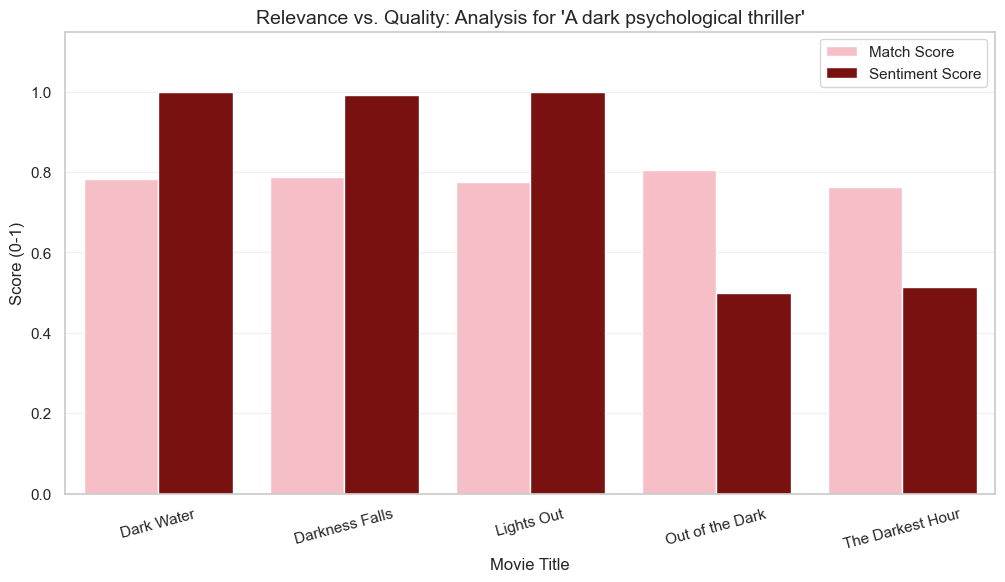

In [149]:
# Define Input Data
query = "A dark psychological thriller"
results = ultimate_recommendation_engine(query)

# Show Table 
show_leaderboard(results, query)

# Show Chart
show_chart(results, query)


<h2 style="color: #8B0000;">3.5 Metrics Explanation</h2>


**Match Score (0–1):**  
* Cosine similarity. Measures thematic fit.
* How well the plot fits your query (from Multi-Task Model)


**Sentiment Score (0–1):**  
* Mean positive probability across reviews. Measures viewer approval.
* Percentage of positive reviews (from Sentiment Classifier).
  
**Final Score:**  
`Final = (Match Score × 0.6) + (Sentiment Score × 0.4)`  
* Balances relevance and real audience quality
* Weighted Average (60% Match + 40% Sentiment)

<h2 style="color: #8B0000;">3.6 Final Movie Recommendations</h2>

**<span style="color:#8B0000;">What if I want to ask for a specific movie, not the plot?</span>**


In [150]:
def get_plot_from_tmdb(movie_title):
    """
    Fetches the plot synopsis of a movie from TMDB API.
    Returns the plot text or None if not found.
    """
    search_url = f"https://api.themoviedb.org/3/search/movie?api_key={API_KEY}&query={movie_title}"
    try:
        response = requests.get(search_url).json()
        if response.get('results'):
            # Return the 'overview' (plot) of the first result
            return response['results'][0]['overview']
        return None
    except Exception:
        return None

def recommend_from_movie(movie_title):
    """
    1. Tries to find the movie in the local dataset.
    2. If not found, fetches the plot from TMDB API.
    3. Uses the found plot as the query for recommendations.
    """
    local_match = df[df['title'].str.lower() == movie_title.lower()]
    
    if not local_match.empty:
        print(f"Found '{local_match.iloc[0]['title']}' in local database!")
        query_plot = local_match.iloc[0]['soup']
    
    # Fallback: Trying TMDB API
    else:
        print(f" '{movie_title}' not in local database. Searching TMDB API...")
        external_plot = get_plot_from_tmdb(movie_title)
        
        if external_plot:
            print(f"Found on TMDB! Using fetched plot...")
            query_plot = external_plot
        else:
            print(f" Movie '{movie_title}' not found locally or on TMDB.")
            return None

    results = ultimate_recommendation_engine(query_plot)
    
    results = results[results['Movie Title'].str.lower() != movie_title.lower()]
    
    return results


In [151]:
################
## T E S T  1 ##
################

# This uses the plot of the input movie to find matches
movie_name = "Finding Nemo"
results = recommend_from_movie(movie_name)

if results is not None:
    show_leaderboard(results, f"Movies like {movie_name}")

Found 'Finding Nemo' in local database!
Analyzing Top 10 candidates...

 FINAL RANKING: 'Movies like Finding Nemo'


,Movie Title,Match Score,Review Count,Sentiment Score,Final Score
2,Dinosaur,0.822261,2,0.998616,0.892803
3,Coraline,0.794918,3,0.998914,0.876516
4,Anastasia,0.795302,1,0.997832,0.876314
5,Tangled,0.787767,4,0.998875,0.872210


In [152]:
################
## T E S T  2 ##
################

movie_name = "Barbie"
results = recommend_from_movie(movie_name)

if results is not None:
    show_leaderboard(results, f"Movies like {movie_name}")

 'Barbie' not in local database. Searching TMDB API...
Found on TMDB! Using fetched plot...
Analyzing Top 10 candidates...

 FINAL RANKING: 'Movies like Barbie'


,Movie Title,Match Score,Review Count,Sentiment Score,Final Score
1,Alvin and the Chipmunks: Chipwrecked,0.711185,2,0.998767,0.826218
2,Alvin and the Chipmunks: The Squeakquel,0.709643,2,0.997433,0.824759
3,Snow White and the Seven Dwarfs,0.703907,1,0.998483,0.821738
4,The Lego Movie,0.696397,2,0.998651,0.817299
5,Willy Wonka & the Chocolate Factory,0.725024,5,0.806805,0.757736


In [153]:
###########################################
# T E S T      F O R     I N - C L A S S #
###########################################
movie_name = "Oceans 8"
results = recommend_from_movie(movie_name)

if results is not None:
    show_leaderboard(results, f"Movies like {movie_name}")

 'Oceans 8' not in local database. Searching TMDB API...
Found on TMDB! Using fetched plot...
Analyzing Top 10 candidates...

 FINAL RANKING: 'Movies like Oceans 8'


,Movie Title,Match Score,Review Count,Sentiment Score,Final Score
1,Drowning Mona,0.713674,1,0.998311,0.827529
2,Ocean's Thirteen,0.706950,1,0.997439,0.823146
3,Nurse Betty,0.698437,1,0.992757,0.816165
4,On the Waterfront,0.683996,4,0.992675,0.807468
5,Ocean's Eleven,0.709024,7,0.854886,0.767369


<h2 style="color: #8B0000;">Concluding Remarks</h2>

Note that the recommendations come exclusively from our local dataset. So the variety of recommendations depends on the size of the initial dataset. 

Our function can handle "Cold Start" inputs (movies it has never seen before).

But it maps them back to our curated catalog (the movies we actually "have" in the database). 

This mimics a real streaming service (e.g., Netflix doesn't have every movie, but if you search for a movie they don't have, they recommend similar ones they do have).